In [5]:
import numpy as np
from sklearn.cluster import k_means

def bkmeans(X:np.ndarray, k:int, i:int) -> np.ndarray:
    """Bisecting k-Means.
    
    Parameters
    ----------
    X : ndarray
        The matrix to perform Bisecting k-Means on.
    k : int
        The number of clusters to end with.
    i : int
        The number of iterations to perform the k-Means with different centroids.
    """
    res = np.zeros(X.shape[0], dtype=int)
    for kk in range(1, k):
        values, counts = np.unique(res, return_counts=True)
        most_common_k = values[counts.argmax()]
        most_common_indices = res == most_common_k
        new_clusters = k_means(X[most_common_indices], 2, n_init=i)[1]
        res[most_common_indices] = np.where(new_clusters == 0, most_common_k, kk)
    return res

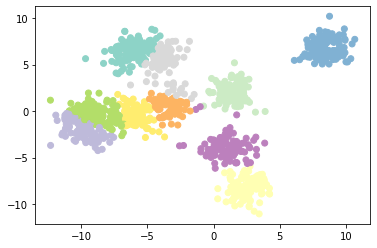

In [61]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, centers=10, n_features=2)
k = 10
c = bkmeans(X, k, 100)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=c, cmap="Set3")
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

def sammons_stress(X, Y):
    """Calculate Sammon's Stress.
    
    Parameters
    ----------
    X : ndarray
        The input matrix.
    Y : ndarray
        The output matrix.
    """
    S = np.triu(X)
    d = np.triu(Y)
    return (1 / np.sum(S)) * np.sum(np.divide(np.square(d - S), S, out=np.zeros_like(S), where=S!=0))

def sammon(X, max_iter=100, epsilon=0.01, alpha=0.3, init="random", verbose=False):
    """Perform Sammon Mapping on X.
    
    Parameters
    ----------
    X : ndarray
        The matrix to reduce the dimensions of.
    max_iter : int
        The maximum number of iterations to perform.
    epsilon : float
        The error threshold, break if Sammon's Stress is lower.
    alpha : float
        The learning rate.
    init : str
        The method to init the resulting matrix with, use "pca" for PCA, else random blobs.
    verbose : boolean
        Use True to print iteration and Sammon's Stress.
    """
    S = pairwise_distances(X)
    S = np.where(S==0, 1e-100, S)
    c = np.sum(np.triu(S))
    y_indices = range(X.shape[0])

    if init.lower() == "pca":
        Y = PCA(n_components=2, random_state=1).fit_transform(X)
    else:
        Y = make_blobs(n_samples=X.shape[0], n_features=2, centers=1, random_state=1337)[0]

    for t in range(max_iter):
        d = pairwise_distances(Y)
        d = np.where(d==0, 1e-100, d)
        E = sammons_stress(S, d)
        if verbose:
            print(f"Iter: {t}, E = {E}")
        if E < epsilon:
            print(f"Error threshold of {epsilon}, reached at iter {t}. E = {E}")
            break

        for i in y_indices:
            first = np.array([0, 0], dtype=np.float64)
            second = np.array([0, 0], dtype=np.float64)
            for j in y_indices:
                if j == i: continue
                first += ((S[i,j] - d[i,j]) / (d[i,j] * S[i,j])) * (Y[i] - Y[j])
                second += (1 / (S[i,j] * d[i,j])) * ( (S[i,j] - d[i,j]) - ((np.square(Y[i] - Y[j]) / d[i,j]) * (1 + ( (S[i,j] - d[i,j]) / d[i,j] ))) )
            
            Y[i] = Y[i] - alpha * ((-2/c)*first)/np.abs((-2/c)*second)
    return Y

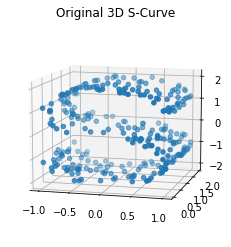

Iter: 0, E = 0.6390167608805878
Iter: 1, E = 0.5175148005749113
Iter: 2, E = 0.40612169133714593
Iter: 3, E = 0.3984854560220881
Iter: 4, E = 0.8242515864190099
Iter: 5, E = 0.815392495840205
Iter: 6, E = 0.3934202564914064
Iter: 7, E = 0.6581460336508639
Iter: 8, E = 2.2875512414144494
Iter: 9, E = 37.61581145892169
Iter: 10, E = 0.13924886420471572
Iter: 11, E = 0.2836469047713173
Iter: 12, E = 0.06175176264341181
Iter: 13, E = 0.03711349529307709
Iter: 14, E = 0.12943485602174357
Iter: 15, E = 0.03167975170605403
Iter: 16, E = 0.027404909329568267
Iter: 17, E = 0.030302637600516692
Iter: 18, E = 0.024473008415141703
Iter: 19, E = 0.023656812164454005
Iter: 20, E = 0.024411275157692276
Iter: 21, E = 0.023264267138415878
Iter: 22, E = 0.022975026269898155
Error threshold of 0.023, reached at iter 22. E = 0.022975026269898155


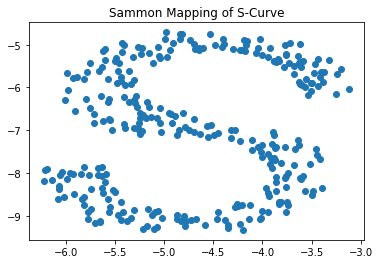

In [4]:
from sklearn.datasets import make_s_curve

X, y = make_s_curve(300, random_state=1)

fig = plt.figure("Original 3D S-Curve")
ax = fig.add_subplot(projection="3d")
ax.title.set_text("Original 3D S-Curve")
ax.view_init(10, 285)
ax.scatter(X[:,0], X[:,1], X[:,2])
plt.show()

Y = sammon(X, max_iter=50, epsilon=0.023, alpha=1, verbose=True)
plt.figure("Sammon Mapping of S-Curve")
plt.title("Sammon Mapping of S-Curve")
plt.scatter(Y[:,0], Y[:,1])

plt.show()

Iter: 0, E = 0.9841608609304249
Iter: 1, E = 1.0625022761765175
Iter: 2, E = 0.9728075570391254
Iter: 3, E = 0.9524899540512173
Iter: 4, E = 0.933938144010808
Iter: 5, E = 0.9650469666234078
Iter: 6, E = 1.0486328387480726
Iter: 7, E = 25.467185698964304
Iter: 8, E = 1.0962080541177337
Iter: 9, E = 1.5911099844678427
Iter: 10, E = 1.0487747381320298
Iter: 11, E = 130.17770776222255
Iter: 12, E = 1.4559187624652454
Iter: 13, E = 0.83791157025057
Iter: 14, E = 3.927316184959712
Iter: 15, E = 2.616713054367248
Iter: 16, E = 0.9828201095113155
Iter: 17, E = 0.5952931004429778
Iter: 18, E = 13.719225267440574
Iter: 19, E = 0.9015779008997152
Iter: 20, E = 0.7196718926918437
Iter: 21, E = 0.7944336034499346
Iter: 22, E = 0.3821715895231355
Iter: 23, E = 0.303721401429696
Iter: 24, E = 0.8626088907857273
Iter: 25, E = 0.22179835094184056
Iter: 26, E = 0.4380270832320908
Iter: 27, E = 0.10250408117664962
Iter: 28, E = 0.06989898378241664
Iter: 29, E = 0.052991338576873534
Iter: 30, E = 0.07061

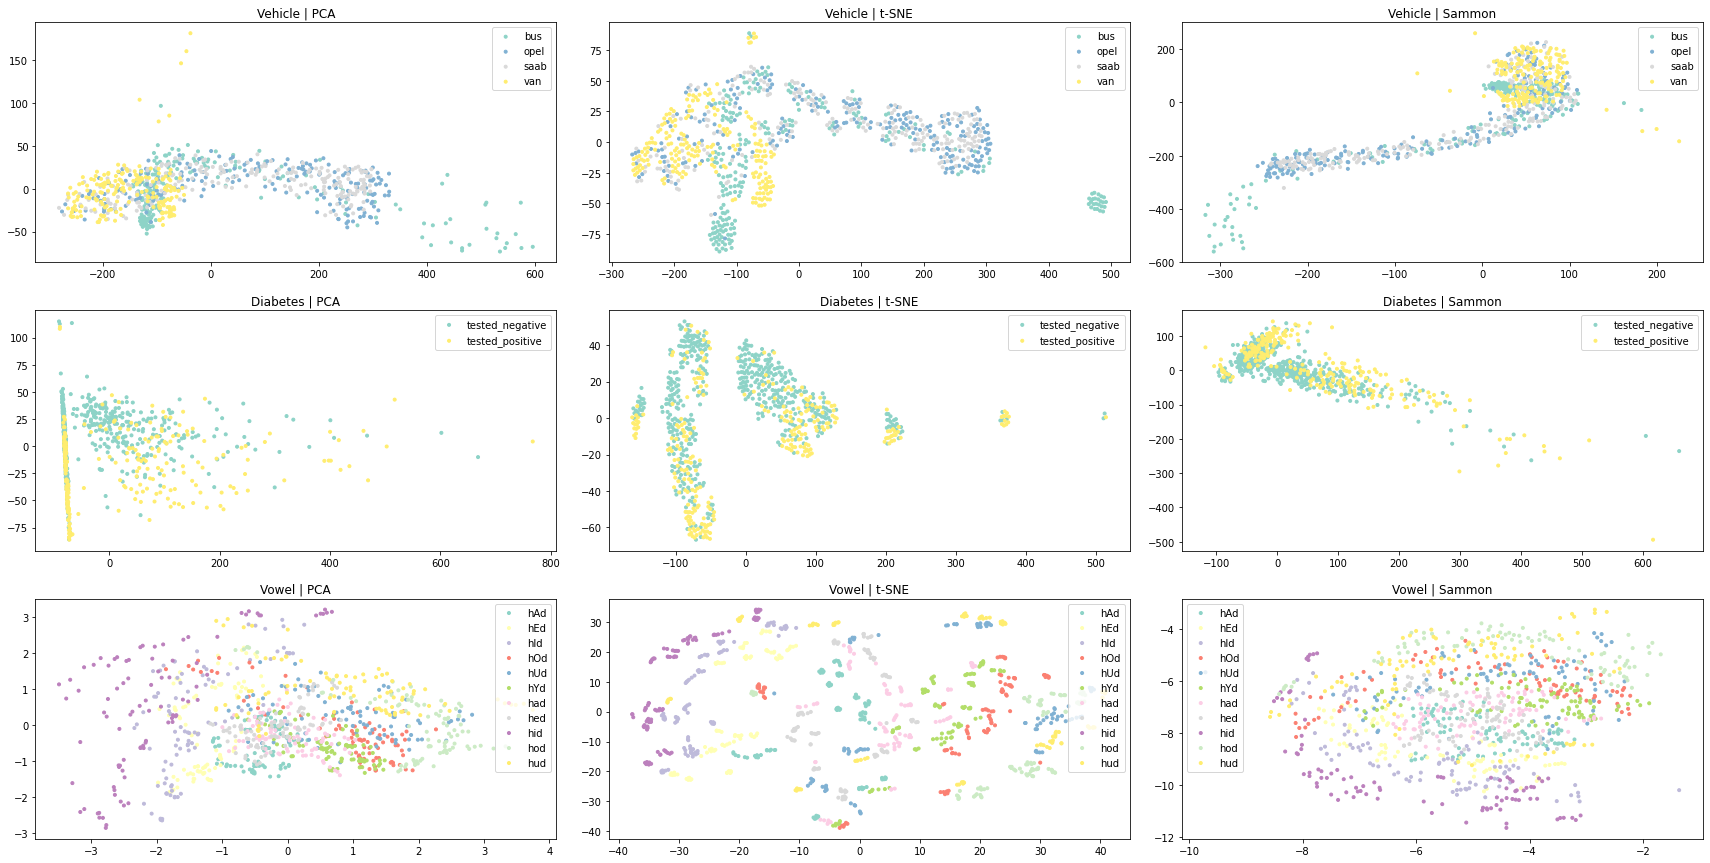

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import warnings
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from scipy.io import arff
warnings.filterwarnings("ignore")

def load_data(file_path, x_lower, x_upper, y_pos):
    data = np.array(arff.loadarff(file_path)[0].tolist())
    X, classes = np.array(data[:, x_lower:x_upper], dtype=np.float64), np.array(data[:, y_pos], dtype=str)
    labels, y = np.unique(classes, return_inverse=True)
    return (X, y, labels)

def plot(X_pca, X_tsne, X_sammon, y, plt_i, labels, title):
    min_y, max_y = min(y), max(y)
    norm = Normalize(vmin=min_y, vmax=max_y)
    cmap = get_cmap("Set3")
    for r, X in enumerate([[X_pca, "PCA"], [X_tsne, "t-SNE"], [X_sammon, "Sammon"]]):
        plt.subplot(3, 3, plt_i + r)
        plt.title(f"{title} | {X[1]}")
        for i, l in enumerate(labels):
            plt.scatter(X[0][y==i, 0], X[0][y==i, 1], c=cmap(norm(y[y==i])), label=l, marker=".")
        plt.legend()


X_v, y_v, labels_v    = load_data("data/vehicle.arff", 0, -1, -1)
X_d, y_d, labels_d    = load_data("data/diabetes.arff", 0, -1, -1)
X_vo, y_vo, labels_vo = load_data("data/vowel.arff", 2, -1, -1)


Y_v_p = PCA(n_components=2).fit_transform(X_v)
Y_v_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_v)
Y_v_s = sammon(X_v, max_iter=50, epsilon=0.01, alpha=1, verbose=True)

Y_d_p = PCA(n_components=2).fit_transform(X_d)
Y_d_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_d)
Y_d_s = sammon(X_d, max_iter=50, epsilon=0.01, alpha=0.3, verbose=True)

Y_vo_p = PCA(n_components=2).fit_transform(X_vo)
Y_vo_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_vo)
Y_vo_s = sammon(X_vo, max_iter=50, epsilon=0.01, alpha=1, verbose=True)


plt.figure(figsize=(24, 12))
plot(Y_v_p, Y_v_t, Y_v_s, y_v, 1, labels_v, "Vehicle")
plot(Y_d_p, Y_d_t, Y_d_s, y_d, 4, labels_d, "Diabetes")
plot(Y_vo_p, Y_vo_t, Y_vo_s, y_vo, 7, labels_vo, "Vowel")
plt.subplots_adjust(left=0.025, bottom=0.025, right=0.99, top=0.97, wspace=0.1, hspace=0.2)
plt.show()

## 3.1
1. For the vehicle dataset I would say t-SNE performed the best.  
   Again, t-SNE seems to perform better for the diabetes dataset. Sammon performs okay, zooming in shows that the overlapping is not as bad as it seems.  
   Looking at the vowel dataset, PCA and Sammon is pretty similar, but t-SNE performs better once again.
2. In the vehicle dataset the classes should be separated by the sillhouettes of four different vehicles.  
   There are only two classes in the diabetes dataset, tested positive and tested negative.
   The vowels dataset should be separated into 11 different classes and we can see that PCA and Sammon are having trouble doing this. It's hard to see any clear grouping.

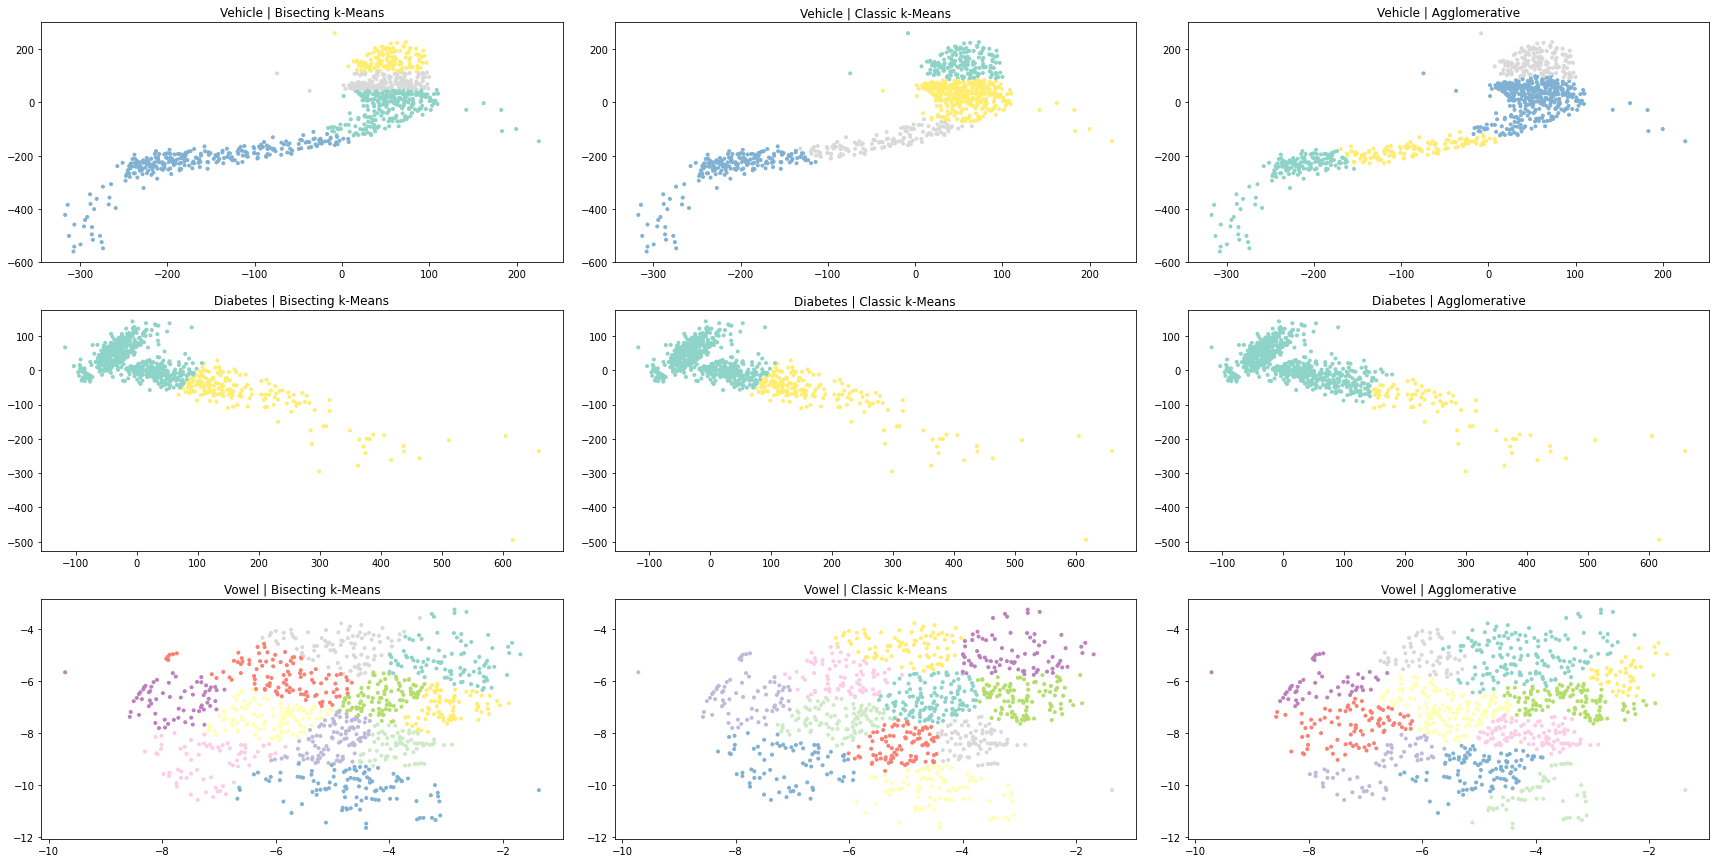

In [66]:
from sklearn.cluster import k_means
from sklearn.cluster import AgglomerativeClustering

def plot_clustering(X_vehicle, X_diabetes, X_vowel, y_vehicle, y_diabetes, y_vowel, labels_vehicle, labels_diabetes, labels_vowel):
    iters = 10
    labels = [labels_vehicle, labels_diabetes, labels_vowel]
    y = [y_vehicle, y_diabetes, y_vowel]
    for r, X in enumerate([X_vehicle, X_diabetes, X_vowel]):
        bkm = bkmeans(X, len(labels[r]), iters)
        km = k_means(X, len(labels[r]), n_init=iters)[1]
        ac = AgglomerativeClustering(len(labels[r])).fit_predict(X)
        for c, Y in enumerate([bkm, km, ac]):
            norm = Normalize(vmin=0, vmax=max(y[r]))
            cmap = get_cmap("Set3")
            plt.subplot(3, 3, [1, 4, 7][r] + c)
            plt.title(f'{["Vehicle", "Diabetes", "Vowel"][r]} | {["Bisecting k-Means", "Classic k-Means", "Agglomerative"][c]}')
            plt.scatter(X[:, 0], X[:, 1], c=cmap(norm(Y)), marker=".")

plt.figure(figsize=(24, 12))
plot_clustering(Y_v_s, Y_d_s, Y_vo_s, y_v, y_d, y_vo, labels_v, labels_d, labels_vo)
plt.subplots_adjust(left=0.025, bottom=0.025, right=0.99, top=0.97, wspace=0.1, hspace=0.2)
plt.show()

## 3.1
For the vehicle dataset I would say the Bisecting k-Means performs the best. It manages to make a cluster (yellow) where there are a lot of green points in the original plot. Ignoring the original labels and colors, I think the Agglomerative clustering performs the best, just looking at the points positions.  

Looking at the diabetes dataset, it's hard data to separate for these clustering algorithms. Bisecting and Classic looks identical and I would say they perform a bit better than the hierarchical as a bit more of the gray points are present. If we ignore the labels and their colors here I would say Bisecting and Classic still performs the best.  

For the last dataset, vowels, it feels like a crapshoot, hard to say which performs the best. If I have to choose, there is something about the classic k-Means that feels a bit better.